In [1]:
import pandas as pd
import pingouin as pg
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt

from plotter_utils import *

from network_utils import *

In [2]:
model_name = 'gpt-3.5-turbo-0613'
cpd_dataset_folder = 'datasets/cpd_debates'
cpd_raw_debates_folder = f'{cpd_dataset_folder}/cpd_debates_raw'
cpd_slices_folder = f'{cpd_dataset_folder}/cpd_debates_slices'
cpd_slices_texts_folder = f'{cpd_dataset_folder}/cpd_debates_slices_text'
cpd_measurements_folder = f'{cpd_dataset_folder}/cpd_debates_measurements'
plots_folder = 'plots'

def load_dataset_raw():
    debates_d, slices_d, paragraphs_d = load_dataset()

    slice_speaker_base_observables = load_slice_and_measured_observables(slices_d)
    speaker_measurements = load_speaker_measurements()

    SS_SSO = speaker_measurements['WS_SS_SSO_measurements']

    SS_SSO_grouped_df, n_raw_observables, n_grouped_observables = prepare_speaker_observables(slice_speaker_base_observables, SS_SSO)

    SS_SSO_grouped_candidates_only_df = SS_SSO_grouped_df[SS_SSO_grouped_df['speaker_party_is_UNKNOWN'] == 0]
    SS_SSO_grouped_candidates_only_df = SS_SSO_grouped_candidates_only_df.drop(columns=['speaker_party_is_UNKNOWN'])

    # remove objects
    SS_SSO_grouped_candidates_only_df = SS_SSO_grouped_candidates_only_df.select_dtypes(exclude=["object"])

    data = SS_SSO_grouped_candidates_only_df
    # data = data.drop('slice_size', axis=1).drop('speaker_is_candidate', axis=1)

    # remove rows that are pretty much constant
    for col in [k for k in data.columns]:
        if abs(np.std(data[col])) < 1e-9:
            data = data.drop(col, axis=1)


    # Drop non-ratio values.
    data = data.drop(['speaker_electoral_votes', 'speaker_popular_votes', 'speaker_quantitative_contribution', 'debate_total_popular_votes'], axis=1)

    return data

def remove_synonyms_and_antonyms(df, threshold):
    # if the abs correlation is > threshold, then combine the vars into one at the level of the samples, if they are antonyms invert one of them, combine the names
    df = df.copy()

    synonym_antonym_sets = []
    for key in list(df.columns):
        for other in list(df.columns):
            if key == other:
                break # already checked in other half

            if abs(df[key].corr(df[other])) > threshold:
                synonym_antonym_sets.append((key, other))
    
    # merge sets that have overlap
    change = True
    while change:
        change = False
        for i, s in enumerate(synonym_antonym_sets):
            for j, o in enumerate(synonym_antonym_sets):
                if i == j:
                    break

                if len(set(s).intersection(set(o))) > 0:
                    synonym_antonym_sets[i] = set(s).union(set(o))
                    synonym_antonym_sets.pop(j)
                    change = True
                    break
            if change: break

    synonym_antonym_sets = [list(sorted(s)) for s in synonym_antonym_sets]

    print(synonym_antonym_sets)

    # merge the unique sets

    for s in synonym_antonym_sets:
        name = ' AND '.join(s)

        first = s[0]
        # flip by the sign of the average correlation to the others
        avg_corr = df[first].corr(df[[k for k in df.columns if k != first]].sum(axis=1))
        if avg_corr < 0:
            df[first] = -df[first]
        
        # flip all by correlation to first in list
        for key in s[1:]:
            if df[first].corr(df[key]) < 0:
                df[key] = -df[key]

        df[name] = df[list(s)].sum(axis=1)
        for key in s:
            df = df.drop(key, axis=1)

    return df

DATASET_RAW = load_dataset_raw()

# remove pro_democratic and pro_republican; too complicated to explain...
DATASET_RAW = DATASET_RAW.drop(['pro democratic', 'pro republican'], axis=1)

DATASET = remove_synonyms_and_antonyms(DATASET_RAW, 0.9)

# combine the pro democratic, etc into one called Speaker Party
name = [k for k in DATASET.columns if 'DEMOCRAT' in k][0]
DATASET['Speaker Party'] = DATASET[name]
DATASET = DATASET.drop(name, axis=1)

datasets = {}

# raw and all
datasets['all'] = {
    # 'raw': DATASET_RAW.copy(),
    'all': DATASET.copy(),
}

# for each observable predict it as a function of all others, but not including all others with 'score' or 'impact' in their names
for key in DATASET.columns:
    ks = [k for k in DATASET.columns if ('score' not in k and 'impact' not in k) or k==key]
    df = DATASET[ks].copy()
    # without outreach
    df2 = df.copy().drop([k for k in df.columns if 'outreach' in k], axis=1)

    datasets[key] = datasets.get(key, {})
    datasets[key]['without_score_impact'] = df
    datasets[key]['without_score_impact_outreach'] = df2

[['speaker_electoral_votes_ratio', 'speaker_popular_votes_ratio'], ['speaker_is_president_candidate', 'speaker_is_vice_president_candidate'], ['speaker_party_is_DEMOCRAT', 'speaker_party_is_REPUBLICAN'], ['debate_elected_party_is_DEMOCRAT', 'debate_elected_party_is_REPUBLICAN']]


In [3]:
def create_matrices(df):
    dis_matrix, _, _ = compute_distance_matrix_from_df(df, flip_sign=False)
    dis_matrix_sign_fix, _, _ = compute_distance_matrix_from_df(df, flip_sign=True)
    dis_matrix_sign_fix_weighted, _, _ = compute_distance_matrix_from_df(df, flip_sign=True, weight_by_correlation_to_others=True)

    return dis_matrix, dis_matrix_sign_fix, dis_matrix_sign_fix_weighted

def create_plots(path, name, dis_matrix, fig_size=(8, 8)):
    print(f'\nComputing {name}\n')
    if not os.path.exists(f'{path}/{name}'):
        os.makedirs(f'{path}/{name}')

    f, ax = plt.subplots(figsize=fig_size)
    cmap = sns.color_palette("coolwarm", 12)
    sns.heatmap(dis_matrix, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{name} Distance Matrix')
    plt.savefig(f'{path}/{name}/DisMatrix.png')

    print('creating DAG')
    g, residual_matrix, fig, ax = create_directed_asyclic_graph(dis_matrix, fig_size=fig_size)
    plt.title(f'{name} DAG')
    plt.savefig(f'{path}/{name}/DAG.png')

    f, ax = plt.subplots(figsize=fig_size)
    cmap = sns.color_palette("coolwarm", 12)
    sns.heatmap(residual_matrix, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{name} Residual Matrix')
    plt.savefig(f'{path}/{name}/ResidualMatrix.png')

    print('creating definitions')
    for target in dis_matrix.columns:
        print(f'creating definitions for {target}')
        folder = f'{path}/{name}/definitions'
        if not os.path.exists(folder):
            os.makedirs(folder)
        with open(f'{folder}/{target}.txt', 'w') as f:
            definitions, accumulated, max_flow_def = dependencies_to_definition(dis_matrix, target, max_depth=1)    
            for i in range(len(definitions)):
                f.write(f'Definition of {target} with exactly {i+1} steps:\n\t{definitions[i]}\n')
                f.write(f'Accumulated definition of {target}:\n\t{accumulated[i]}\n\n')
            f.write(f'\nMax Flow Definition of {target}:\n\t{max_flow_def}\n')
    
    # save as graphml for yed
    print('creating graphml')
    import pyyed

    pg = pyyed.Graph()
    for node in g.nodes:
        # add light grey nodes
        pg.add_node(node, label=f'{node}', font_size="12", height="20", shape_fill="#eeeeee")
    for s, e, d in g.edges(data=True):
        pg.add_edge(s, e, label=f'{d["weight"]:.3f}', width=f'{abs(d["weight"])*10}')
    pg.write_graph(f'{path}/{name}/DAG.graphml')

def create_all_plots(df, path, name, fig_size=(8, 8)):
    path = f'{path}/{name}'
    if not os.path.exists(path):
        os.makedirs(path)

    print('computing corr matrix')
    # create corr matrix plot
    cxy = df.corr()
    # find 'score' or first containing 'score', otherwise first containing 'impact'
    if 'score' in cxy.columns:
        key = 'score'
    else:
        key = [k for k in cxy.columns if 'score' in k or 'impact' in k]
        if len(key) == 0:
            key = cxy.columns[0]
        else:
            key = key[0]
    cxy.sort_values(by=key, ascending=False, inplace=True)
    cxy.sort_values(by=key, axis=1, ascending=False, inplace=True)

    print('plotting corr matrix')
    f, ax = plt.subplots(figsize=fig_size)
    cmap = sns.color_palette("coolwarm", 12)
    sns.heatmap(df.corr(), cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{name} Correlation Matrix')
    plt.savefig(f'{path}/CorrMatrix.png')

    print('computing dis matrices')
    dis_matrix, dis_matrix_sign_fix, dis_matrix_sign_fix_weighted = create_matrices(df)

    create_plots(path, name, dis_matrix, fig_size=fig_size)
    create_plots(path, f'{name}_SignFix', dis_matrix_sign_fix, fig_size=fig_size)
    create_plots(path, f'{name}_SignFix_Weighted', dis_matrix_sign_fix_weighted, fig_size=fig_size)

    create_plots(path, f'{name} minus transposed', dis_matrix - dis_matrix.T, fig_size=fig_size)
    create_plots(path, f'{name}_SignFix minus transposed', dis_matrix_sign_fix - dis_matrix_sign_fix.T, fig_size=fig_size)
    create_plots(path, f'{name}_SignFix_Weighted minus transposed', dis_matrix_sign_fix_weighted - dis_matrix_sign_fix_weighted.T, fig_size=fig_size)

    # don't render saved plots in notebook
    plt.close('all')

In [4]:
# create some random graphs and check how well they are reconstructed
NUM_SAMPLES = int(1e5)

# create df with 1000 entries randomly selected from a normal distribution for variable A, B, C and H and D = A + B + C + H and put into a dataframe
A = np.random.normal(0, 1, NUM_SAMPLES)
B = np.random.normal(0, 1, NUM_SAMPLES)
C = np.random.normal(0, 1, NUM_SAMPLES)
H1 = np.random.normal(0, 1, NUM_SAMPLES)
H2 = np.random.normal(0, 1, NUM_SAMPLES)

XX = pd.DataFrame({
    'A': A.copy(),
    'A2': -A.copy() + H2.copy()/2,
    'B': B.copy(),
    'C': C.copy(),
    # 'H': H.copy(), 
    'D': A.copy() + B.copy() + C.copy() + H1.copy(),
    # 'E': A.copy() + B.copy() + C.copy() + H1.copy() + H2.copy(),
}, dtype=np.float64)

In [5]:
import plotly.graph_objects as go

# dis matrix to go figure
def dis_matrix_to_go_figure(dis_matrix, title, num_edges, occupancy_nodes=0.7, occupancy_links=0.3, source='Speaker Party'):
    dis_matrix = dis_matrix.copy()

    links = []
    edges = sorted([(i, j, dis_matrix[t][s]) for i, s in enumerate(dis_matrix.columns) for j, t in enumerate(dis_matrix.columns) if i != j and dis_matrix[t][s] > 0.], key=lambda x: x[2], reverse=True)
    for i, j, d in edges[:num_edges]:
        links.append(dict(source=i, target=j, value=d))
    
    for i, j, d in edges[num_edges:]:
        dis_matrix.iloc[j, i] = 0.

    nodes = list(dis_matrix.columns)
    colors = sns.color_palette("rainbow", len(dis_matrix.columns))
    colors = [list(c) for c in colors]

    # make red colors less red
    for i, c in enumerate(colors):
        colors[i][0] = colors[i][0]*0.7

    # change color of source to red and add some red to all others it influences within 2 steps weighted by distance
    source_index = nodes.index(source)
    colors[source_index] = [1, 0, 0]
    for i, s in enumerate(dis_matrix.columns):
        if i == source_index:
            continue
        if dis_matrix[source][s] > 0.:
            w = min(1., dis_matrix[source][s]*10)
            colors[i][0] = colors[i][0] * (1-w) + w
            colors[i][1] = colors[i][1] * (1-w)
            colors[i][2] = colors[i][2] * (1-w)

    colors_nodes = {k: f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {occupancy_nodes})' for k, c in zip(dis_matrix.columns, colors)}
    colors_links = {k: f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {occupancy_links})' for k, c in zip(dis_matrix.columns, colors)}

    
    # make figure taller
    fig = go.Figure(
        go.Sankey(
            arrangement='freeform',
            node=dict(
                label=nodes,
                color=[colors_nodes[k] for k in nodes],
                pad=10  
            ),
            link=dict(
                arrowlen=15,
                source=[l['source'] for l in links],
                target=[l['target'] for l in links],
                value=[l['value'] for l in links],
                color=[colors_links[nodes[l['source']]] for l in links],
            ),
        ),
    )

    return fig

In [13]:
# dis_matrix, _, _ = compute_distance_matrix_from_df(datasets['score']['without_score_impact'])
# dis_matrix, _, _ = compute_distance_matrix_from_df(datasets['academic score']['without_score_impact'])
# dis_matrix, _, _ = compute_distance_matrix_from_df(datasets['academic score']['without_score_impact_outreach'])

df = datasets['election score']['without_score_impact'].copy()
# df = datasets['academic score']['without_score_impact'].copy()
# df = datasets['academic score']['without_score_impact_outreach'].copy()
# df = datasets['score']['without_score_impact_outreach'].copy()
# df = datasets['score']['without_score_impact'].copy()

# df = df.drop('decorum', axis=1)
df = df.drop('logical', axis=1)

dis_matrix, _, _ = compute_distance_matrix_from_df(df)
# dis_matrix_sign_fix, _, _ = compute_distance_matrix_from_df(df, flip_sign=True)

In [14]:
XX = dis_matrix.copy()
# XX = dis_matrix_sign_fix

# fig = dis_matrix_to_go_figure(XX, 'Distance Matrix', num_edges=40, occupancy_nodes=0.7, occupancy_links=0.3, source='Speaker Party')
fig = dis_matrix_to_go_figure(XX, 'Distance Matrix', num_edges=200, occupancy_nodes=0.7, occupancy_links=0.3, source='Speaker Party')

# save to jpg
# fig.write_image(f'test.jpg')
# fig.show()
# # show in browser
import plotly.io as pio
pio.renderers.default = "browser"
fig.show()

In [7]:
# test
create_all_plots(XX, f'{plots_folder}/network_analysis_automated_plots', 'test', fig_size=(8, 8))


Computing test

creating DAG
creating definitions
creating definitions for A
creating definitions for A2
creating definitions for B
creating definitions for C
creating definitions for D
creating graphml

Computing test_SignFix

creating DAG
creating definitions
creating definitions for A
creating definitions for A2
creating definitions for B
creating definitions for C
creating definitions for D
creating graphml

Computing test_SignFix_Weighted

creating DAG
creating definitions
creating definitions for A
creating definitions for A2
creating definitions for B
creating definitions for C
creating definitions for D
creating graphml

Computing test minus transposed

creating DAG
creating definitions
creating definitions for A
creating definitions for A2
creating definitions for B
creating definitions for C
creating definitions for D
creating graphml

Computing test_SignFix minus transposed

creating DAG
creating definitions
creating definitions for A
creating definitions for A2
creating de

In [8]:
# test for random graphs
def create_samples_from_directed_graph(g, initial_distribution, flow_function):
    assert(nx.is_directed_acyclic_graph(g))
    g = g.copy()

    # data = [initial_distribution(n['weight']) for k, n in g.nodes(data=True)]
    # data = np.array(data)
    ic = initial_distribution()
    data = [np.zeros_like(ic) for k in g.nodes]
    data = np.array(data)


    df = pd.DataFrame(data.T, columns=g.nodes, dtype=np.float64)

    # get a set of all nodes that have no incoming edges, then add the distribution to them, then remove
    while len(g.nodes) > 0:
        nodes = [n for n in g.nodes if len(list(g.predecessors(n))) == 0]
        for n in nodes:
            ic = initial_distribution()
            # add ic with weight to node
            std = np.std(df[n])
            if np.abs(std) < 1e-9:
                df[n] = ic
            else:
                df[n] = (df[n] - np.mean(df[n])) / std
                df[n] += ic * g.nodes[n]['weight']

            # add value to all successors
            for _, e, d in g.out_edges(n, data=True):
                if df.get(s, None) is None:
                    df[e] = np.zeros_like(ic)
                df[e] += flow_function(df[n], d['weight'])
            
            # remove node
            g.remove_node(n)

    return df

initial_distribution = lambda: np.random.normal(0, 1, NUM_SAMPLES)
flow_function = lambda x, w: x * w

# create a random graph
for i in range(2):
    folder = f'{plots_folder}/network_analysis_automated_plots/random_graphs'
    name = f'Random Graph {i}'

    GRAPH_SIZE = 6

    # # random directed acyclic graph
    # g = nx.DiGraph()
    # for i in range(GRAPH_SIZE):
    #     g.add_node(str(i))

    # # while len(g.edges) < GRAPH_SIZE*2:
    # while len(g.edges) < int(GRAPH_SIZE*1.3):
    #     # choose a random edge, if it is not already in the graph and doesn't create a cycle, add it
    #     s = str(np.random.randint(0, GRAPH_SIZE))
    #     e = str(np.random.randint(0, GRAPH_SIZE))

    #     if s == e or g.has_edge(s, e) or nx.has_path(g, e, s):
    #         continue

    #     g.add_edge(s, e)

    # random tree
    g = nx.random_tree(GRAPH_SIZE, create_using=nx.DiGraph)
    # change node names to str
    g = nx.relabel_nodes(g, {k: str(k) for k in g.nodes})

    # invert all edges
    g = g.reverse()

    # add node weights
    for n in g.nodes:
        g.nodes[n]['weight'] = np.random.uniform(1.0, 2.0)

    # add weights
    for s, e in g.edges:
        # g[s][e]['weight'] = np.random.uniform(-3, 3)
        g[s][e]['weight'] = np.random.uniform(0.4, 1.3)
        # g[s][e]['weight'] *= np.random.choice([-1, 1])
        # with 10% chance flip
        # if np.random.uniform(0, 1) < 0.1:
        #     g[s][e]['weight'] *= -1
    
    # create samples
    samples = create_samples_from_directed_graph(g, initial_distribution, flow_function)

    if not os.path.exists(f'{folder}/{name}'):
        os.makedirs(f'{folder}/{name}')

    # plot real_graph
    fig, ax = plot_dag(g, fig_size=(8, 8))
    plt.savefig(f'{folder}/{name}/Real_Graph.png')
    
    # plot all
    create_all_plots(samples, folder, name, fig_size=(8, 8))


Computing Random Graph 0

creating DAG
creating definitions
creating definitions for 0
creating definitions for 1
creating definitions for 2
creating definitions for 3
creating definitions for 4
creating definitions for 5
creating graphml

Computing Random Graph 0_SignFix

creating DAG
creating definitions
creating definitions for 0
creating definitions for 1
creating definitions for 2
creating definitions for 3
creating definitions for 4
creating definitions for 5
creating graphml

Computing Random Graph 0_SignFix_Weighted

creating DAG
creating definitions
creating definitions for 0
creating definitions for 1
creating definitions for 2
creating definitions for 3
creating definitions for 4
creating definitions for 5
creating graphml

Computing Random Graph 0 minus transposed

creating DAG
creating definitions
creating definitions for 0
creating definitions for 1
creating definitions for 2
creating definitions for 3
creating definitions for 4
creating definitions for 5
creating graphm

name=all, key=all
computing corr matrix
plotting corr matrix
computing dis matrices


KeyboardInterrupt: 

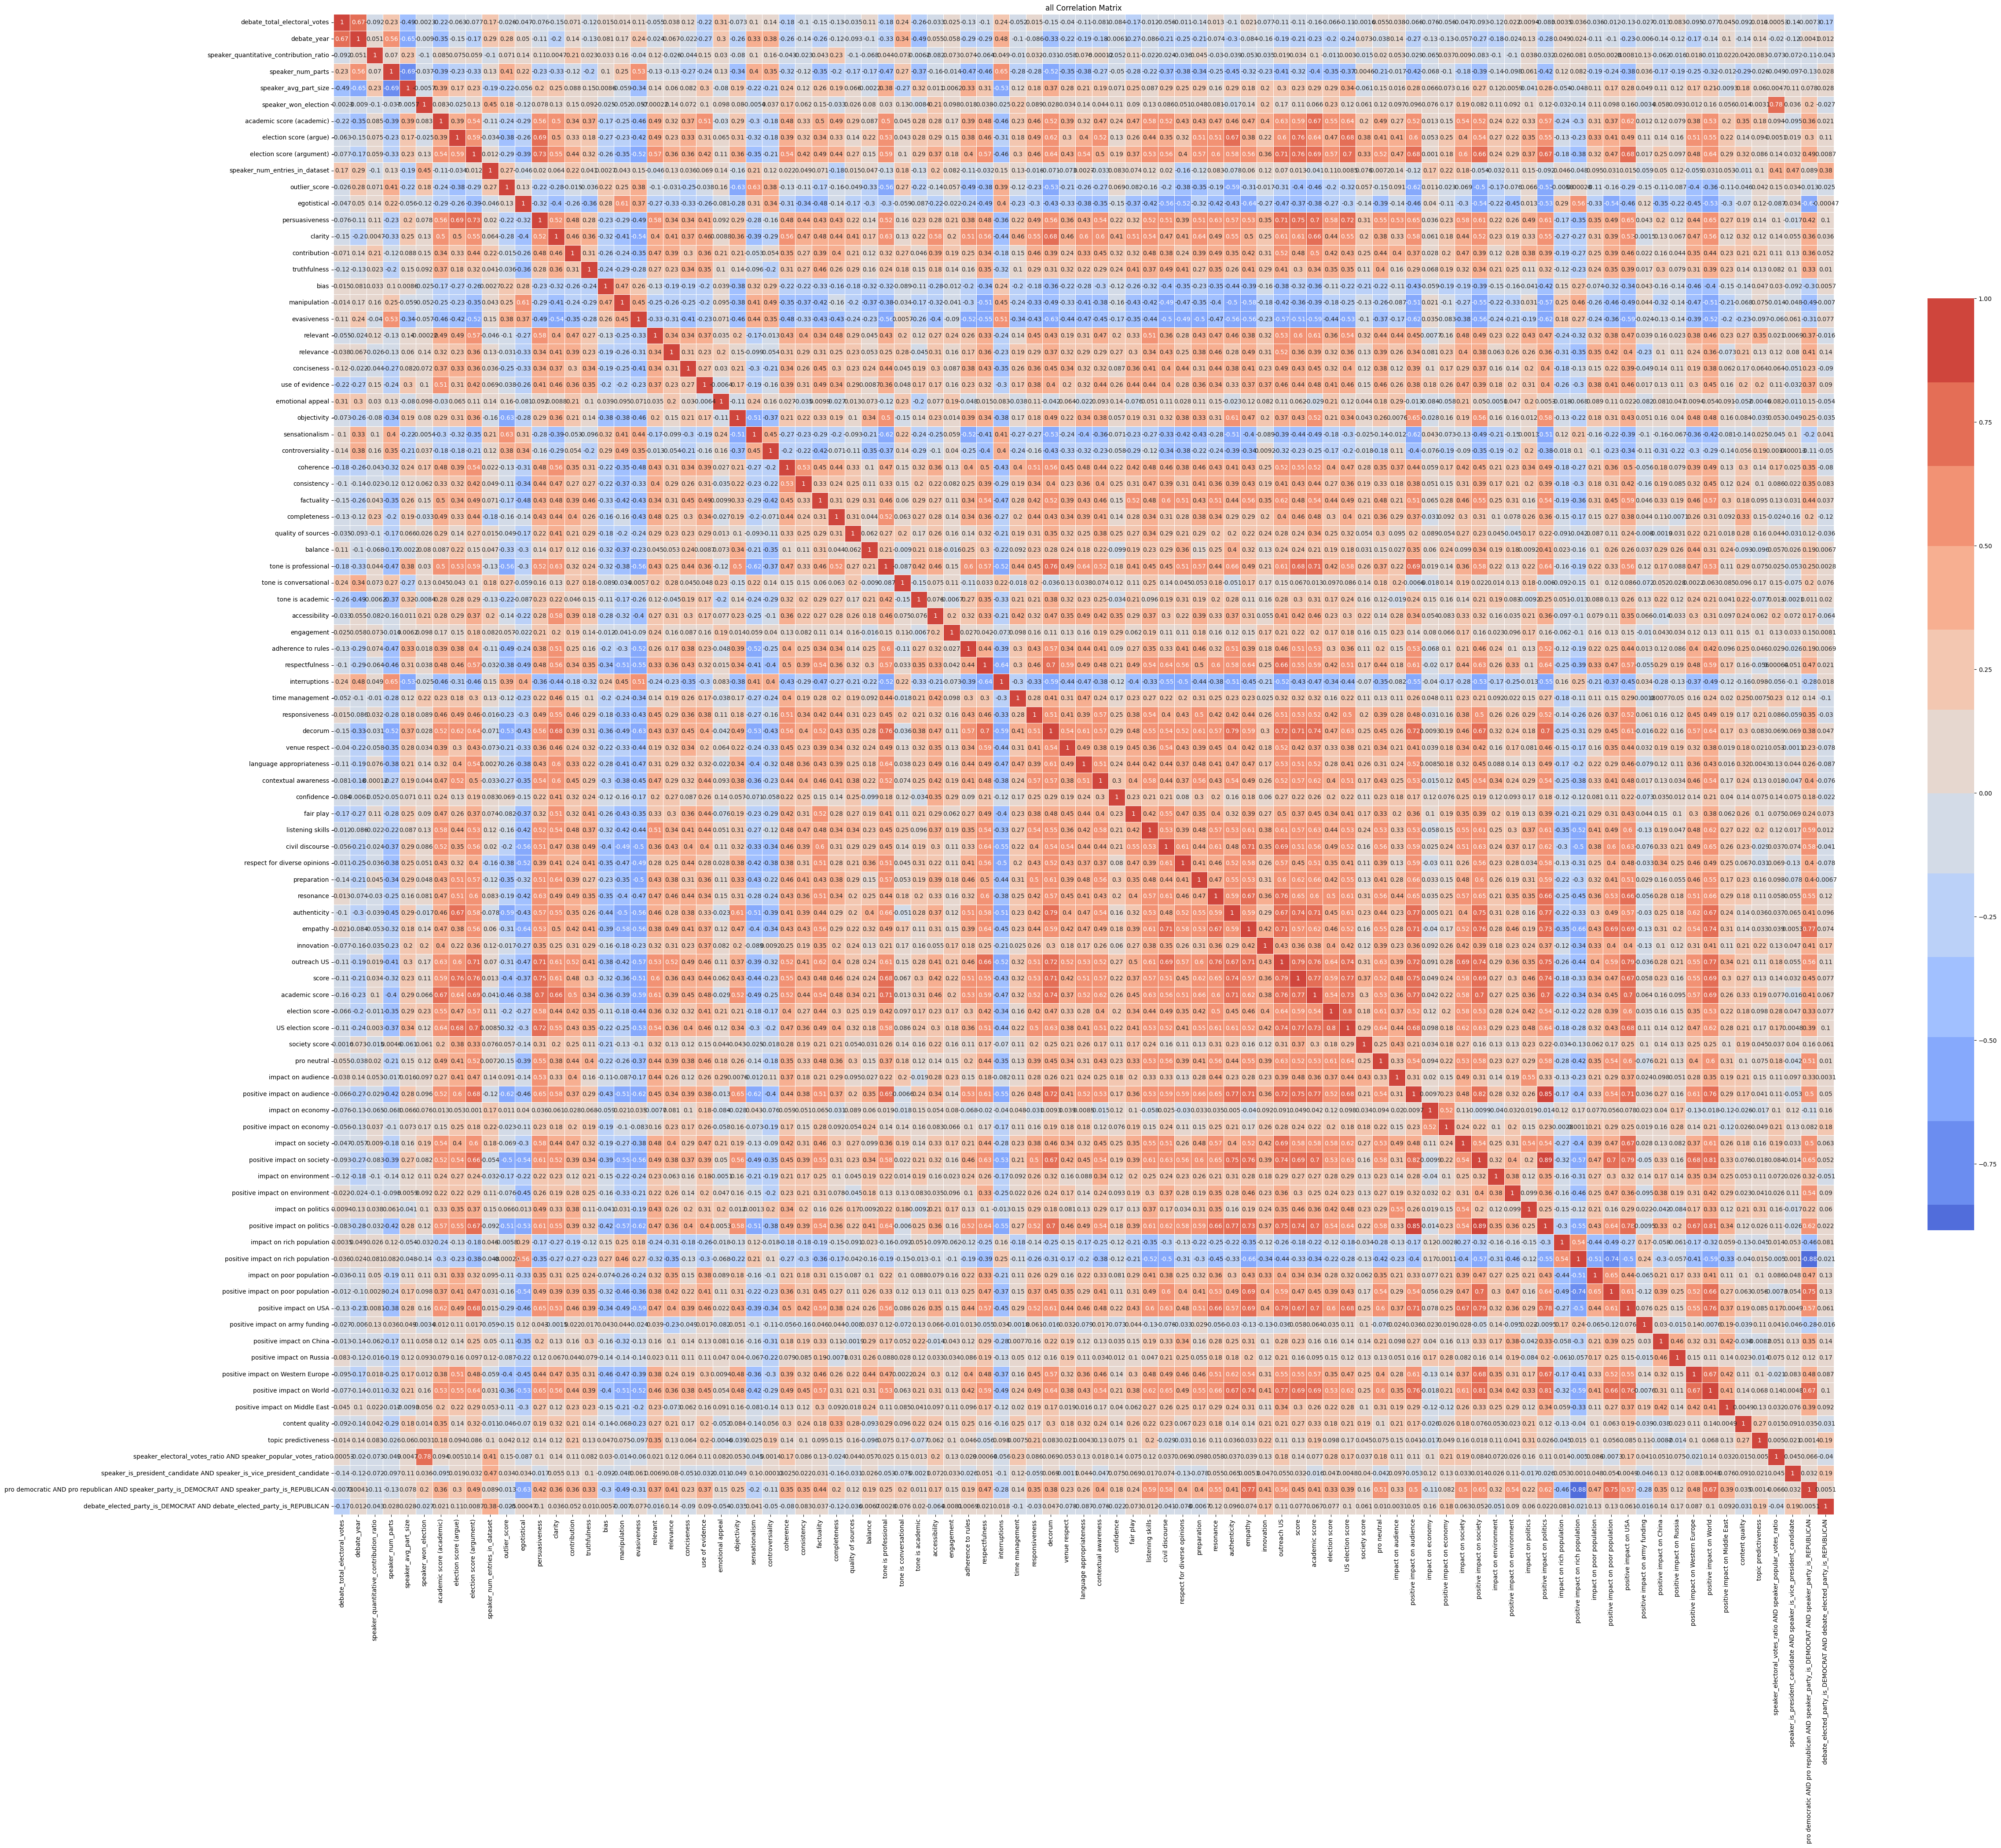

In [4]:
# create the plots for all datasets
for key, dataset in datasets.items():
    for name, df in dataset.items():
        print(f'name={name}, key={key}')
        path = f'{plots_folder}/network_analysis_automated_plots/{key}'
        create_all_plots(df, path, name, fig_size=(55, 55))